# Imports.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
import keras
import torch
import tensorflow as tf
from sklearn.model_selection import train_test_split
import random 

from keras.models import Model
from keras.models import Sequential
from keras import layers
from keras.layers.core import Dense
from keras.layers import Activation, Conv1D, Flatten, LSTM, Dropout


Using TensorFlow backend.


# Read the data.

In [2]:
# Get raw data from dataset.
raw_data = pd.read_csv("/Users/ilaigenishmac/Downloads/games.csv")

# Describe the initial data.

In [3]:
display(raw_data.head(3))

,id,rated,created_at,last_move_at,turns,victory_status,winner,increment_code,white_id,white_rating,black_id,black_rating,moves,opening_eco,opening_name,opening_ply
0,TZJHLljE,False,1.504210e+12,1.504210e+12,13,outoftime,white,15+2,bourgris,1500,a-00,1191,d4 d5 c4 c6 cxd5 e6 dxe6 fxe6 Nf3 Bb4+ Nc3 Ba5...,D10,Slav Defense: Exchange Variation,5
1,l1NXvwaE,True,1.504130e+12,1.504130e+12,16,resign,black,5+10,a-00,1322,skinnerua,1261,d4 Nc6 e4 e5 f4 f6 dxe5 fxe5 fxe5 Nxe5 Qd4 Nc6...,B00,Nimzowitsch Defense: Kennedy Variation,4
2,mIICvQHh,True,1.504130e+12,1.504130e+12,61,mate,white,5+10,ischia,1496,a-00,1500,e4 e5 d3 d6 Be3 c6 Be2 b5 Nd2 a5 a4 c5 axb5 Nc...,C20,King's Pawn Game: Leonardis Variation,3


In [4]:
display(raw_data[['turns','white_rating','black_rating']].describe())

,turns,white_rating,black_rating
count,20058.000000,20058.000000,20058.000000
mean,60.465999,1596.631868,1588.831987
std,33.570585,291.253376,291.036126
min,1.000000,784.000000,789.000000
25%,37.000000,1398.000000,1391.000000
50%,55.000000,1567.000000,1562.000000
75%,79.000000,1793.000000,1784.000000
max,349.000000,2700.000000,2723.000000


# Pre-processing.

#### $\bullet$ We take only games with 40 moves or more (since the net inputs are the first 40 moves) and order the data.

In [5]:
moves_number = 40
# Take only games with 40 moves or more.
raw_data = raw_data[raw_data['turns']>moves_number]

# Take usefull features for prediction.
raw_data = raw_data[['moves','winner']]

# Filter the data from all rows (instances) containing one or more null values.
raw_data.dropna(axis = 0, how = "any", inplace=True)
 
# Convert moves from string to list of strings.
raw_data['moves']= raw_data['moves'].apply(lambda x: np.array(x.split()))

raw_data.head(3)

,moves,winner
2,"[e4, e5, d3, d6, Be3, c6, Be2, b5, Nd2, a5, a4...",white
3,"[d4, d5, Nf3, Bf5, Nc3, Nf6, Bf4, Ng4, e3, Nc6...",white
4,"[e4, e5, Nf3, d6, d4, Nc6, d5, Nb4, a3, Na6, N...",white


Total instances number after filtering games 
with less then 10 moves: 11407 

white    5437
black    5260
draw      710
Name: winner, dtype: int64


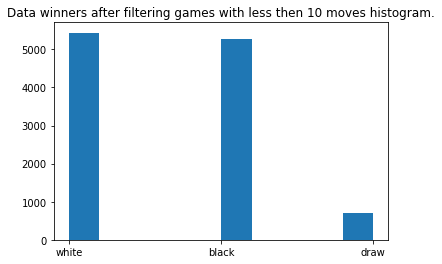

In [6]:
# Describe filtered the data.
plt.hist(np.array(raw_data[["winner"]]))
plt.title("Data winners after filtering games with less then 40 moves histogram.")
print("Total instances number after filtering games \nwith less then 40 moves:", raw_data.shape[0],"\n")
print(raw_data.winner.value_counts())


#### $\bullet$ We add for each move from the first 10 moves a column in the data set. 

In [7]:
# Get moves list for each game.
game_moves_list = []
moves_list = raw_data.moves

# Take only the first 40 moves from each game.
for i,instance in enumerate(moves_list, 1):
    instance_moves = instance[0:moves_number]
    game_moves_list.append(instance_moves)
game_moves_list = np.array(game_moves_list)

# Add moves columns to the data frame.
for i in range(0,moves_number):
    raw_data['move_'+ str(i+1)] = game_moves_list.T[i]
    
raw_data



,moves,winner,move_1,move_2,move_3,move_4,move_5,move_6,move_7,move_8,...,move_41,move_42,move_43,move_44,move_45,move_46,move_47,move_48,move_49,move_50
2,"[e4, e5, d3, d6, Be3, c6, Be2, b5, Nd2, a5, a4...",white,e4,e5,d3,d6,Be3,c6,Be2,b5,...,exf7,Nf6,Rxh8,Nh5,Bxh5,Kg5,Rxh7,Kf5,Qf3+,Ke6
3,"[d4, d5, Nf3, Bf5, Nc3, Nf6, Bf4, Ng4, e3, Nc6...",white,d4,d5,Nf3,Bf5,Nc3,Nf6,Bf4,Ng4,...,Ra7+,Ke6,Qe8+,Kf5,Qxf7+,Nf6,Nh4+,Kg5,g3,Ng4
4,"[e4, e5, Nf3, d6, d4, Nc6, d5, Nb4, a3, Na6, N...",white,e4,e5,Nf3,d6,d4,Nc6,d5,Nb4,...,Rfd1,Re8,Qxd6,Bg4,Qxf6,gxf6,Rd3,Bxf3,Rxf3,Rd8
8,"[e4, e5, Bc4, Nc6, Nf3, Nd4, d3, Nxf3+, Qxf3, ...",black,e4,e5,Bc4,Nc6,Nf3,Nd4,d3,Nxf3+,...,Qf4,Nh5,Qg4,Nf6,Qf4,Qa5,Bc2,Qe1+,Kh2,Nh5
9,"[e4, d5, exd5, Qxd5, Nc3, Qe5+, Be2, Na6, d4, ...",white,e4,d5,exd5,Qxd5,Nc3,Qe5+,Be2,Na6,...,Nb4,Bxb4+,c3,Ba5,b4,Bc7,Bxc7,Rxc7,Rb1,e5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20047,"[c4, d5, e3, dxc4, Bxc4, Nc6, a3, Ne5, d4, Nxc...",white,c4,d5,e3,dxc4,Bxc4,Nc6,a3,Ne5,...,Bd2,Rxg2+,Kh1,Rg3+,f3,Rh3,Rac1,Kd7,Qd4+,Ke8
20051,"[e4, e6, Nf3, d5, Bb5+, Bd7, c4, c6, Ba4, Qa5,...",black,e4,e6,Nf3,d5,Bb5+,Bd7,c4,c6,...,Bxa1,Nd4,Kf1,Rd8,Qd3,Bc1,Qe4,Qa3,Qxe5+,Ne6
20054,"[d4, d6, Bf4, e5, Bg3, Nf6, e3, exd4, exd4, d5...",black,d4,d6,Bf4,e5,Bg3,Nf6,e3,exd4,...,Qe2,Nc6,Re1,g6,f4,Rxh1+,Kxh1,Qh6+,Kg1,a5
20056,"[e4, d6, d4, Nf6, e5, dxe5, dxe5, Qxd1+, Kxd1,...",white,e4,d6,d4,Nf6,e5,dxe5,dxe5,Qxd1+,...,h4,h6,e5,b5,cxb6,Be7,bxa7,Kc7,a3,Rhf8


#### $\bullet$ One Hot Encoding.

In [8]:
# This function change dictionary (with unique) values to one hot coding representation. 
def encode_dict(dictionary):
    dict_size = len(dictionary)
    identity_matrix = np.identity(dict_size)
    for key in dictionary.keys():
        dictionary[key] = identity_matrix[dictionary[key]]
    
    return dictionary

#### $\bullet$ One Hot Encoding for moves.

In [9]:
#Create encoding dictionary for moves.
encoding_moves_dict = {}
dict_size=0 

# Shuffle the moves instaces.
moves_list = np.random.permutation(moves_list)

# Give each move unique number.
for game_moves in moves_list:

    for move in game_moves:

        if move not in encoding_moves_dict:
            encoding_moves_dict[move] = dict_size
            dict_size += 1

encoding_moves_dict = encode_dict(encoding_moves_dict)

In [10]:
# Encode the moves in the data frame.
for i in range(0, moves_number):
    raw_data['move_'+ str(i+1)] = raw_data['move_'+ str(i+1)].apply(lambda x: encoding_moves_dict[x])
    

In [11]:
# Drop the moves column from the from data.
raw_data = raw_data.drop('moves', axis = 1)

#### $\bullet$ One Hot Encoding for winner.

In [12]:
# Create encoding dictionary for winner.
winners_list = raw_data['winner']
encoding_winners_dict = {}
dict_size=0 

# shuffle the feature
winners_list = np.random.permutation(winners_list)

# add values to the dictionery.
for winner_status in winners_list:
        if winner_status not in encoding_winners_dict:
            encoding_winners_dict[winner_status] = dict_size
            dict_size += 1
encoding_winners_dict = encode_dict(encoding_winners_dict)

In [13]:
# Encode the winners in the data frame.
raw_data['winner'] = raw_data['winner'].apply(lambda x: encoding_winners_dict[x])

# Describe pre-processed data.

In [14]:
raw_data

,winner,move_1,move_2,move_3,move_4,move_5,move_6,move_7,move_8,move_9,...,move_41,move_42,move_43,move_44,move_45,move_46,move_47,move_48,move_49,move_50
2,"[0.0, 0.0, 1.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,"[0.0, 0.0, 1.0]","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,"[0.0, 0.0, 1.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...","[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
8,"[1.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0

# Split data to train, validation and test.

In [15]:
# Correcting moves shape to match keras model.
moves = raw_data.drop(columns=['winner'])
moves = np.array(torch.Tensor(list(moves.values)))

# Correcting labels shape to match keras model.
labels =raw_data.take([0], axis = 1)
labels = np.array([label[0] for label in labels.values])

# Split the data to train and test.
X_train, X_test, y_train, y_test = train_test_split(moves, labels, test_size=0.3, shuffle=True, random_state=42)

# Split the test to test and validation.
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, shuffle=True, random_state=43)


In [16]:
# Print shapes
print('X train shape: ', X_train.shape)
print('X test shape: ', X_test.shape)
print('X validation shape: ', X_val.shape, '\n')

print('y train shape: ', y_train.shape)
print('y test shape: ', y_test.shape)
print('y validation shape: ', y_val.shape)


X train shape:  (7984, 50, 4291)
X test shape:  (1711, 50, 4291)
X validation shape:  (1712, 50, 4291) 

y train shape:  (7984, 3)
y test shape:  (1711, 3)
y validation shape:  (1712, 3)


# Build LSTM model net for winner prediction.

In [28]:
lstm_model = Sequential()

lstm_model.add(LSTM(81))
lstm_model.add(Dense(27, activation='relu'))
lstm_model.add(Dropout(0.2))
lstm_model.add(Dense(9, activation='relu'))
lstm_model.add(Dense(3, activation='softmax'))

lstm_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train LSTM model.

In [29]:
lstm_model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=5, verbose=1)
lstm_model.summary()

Train on 7984 samples, validate on 1712 samples
Epoch 1/5
7984/7984 [==============================] - 143s 18ms/step - loss: 0.9066 - accuracy: 0.4827 - val_loss: 0.8714 - val_accuracy: 0.4661
Epoch 2/5
7984/7984 [==============================] - 135s 17ms/step - loss: 0.8630 - accuracy: 0.5550 - val_loss: 0.8336 - val_accuracy: 0.5888
Epoch 3/5
7984/7984 [==============================] - 132s 17ms/step - loss: 0.7777 - accuracy: 0.6278 - val_loss: 0.8528 - val_accuracy: 0.5964
Epoch 4/5
7984/7984 [==============================] - 132s 17ms/step - loss: 0.6904 - accuracy: 0.6769 - val_loss: 0.8791 - val_accuracy: 0.5859
Epoch 5/5
7984/7984 [==============================] - 132s 16ms/step - loss: 0.5926 - accuracy: 0.7474 - val_loss: 0.9745 - val_accuracy: 0.5584
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 81)                1416852   
__

# Evaluate LSTM model preformence.

In [19]:
# Predict (decoded) labels for test.
lstm_y_pred=lstm_model.predict_classes(X_test)

# Decode test real labels (test winners).
decode_y_test = [np.argmax(label) for label in y_test]

# Create confusion matrix for laybel class.
lstm_con_mat = tf.math.confusion_matrix(labels=decode_y_test, predictions=lstm_y_pred).numpy()

print(lstm_con_mat)

[[462  51 283]
 [ 51  14  36]
 [304  42 468]]


black - 0
draw - 1
white - 2


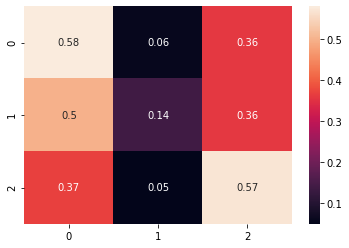

In [20]:
# Confusion matrix visualization.
lstm_con_mat_norm = np.around(lstm_con_mat.astype('float') / lstm_con_mat.sum(axis=1)[:, np.newaxis],
                              decimals=2)
 
lstm_con_mat_df = pd.DataFrame(lstm_con_mat_norm,
                               index = ['0','1','2'], 
                               columns = ['0','1','2'])

# Print labels class values.
for key in encoding_winners_dict.keys():
    print(key,"-",np.argmax(encoding_winners_dict[key]))

# Plot heatmap.
sns.heatmap(lstm_con_mat_norm, annot=True)

In [21]:
# Get test accuracy.
_, lstm_accuracy = lstm_model.evaluate(X_test, y_test, verbose=1)
lstm_accuracy

1711/1711 [==============================] - 5s 3ms/step


0.5517241358757019

# Build CNN model net for winner prediction.

In [22]:
cnn_model = Sequential()

cnn_model.add(Conv1D(filters=2, kernel_size=3))
cnn_model.add(Activation('relu'))
cnn_model.add(Flatten())
cnn_model.add(Dense(81, activation='relu'))
cnn_model.add(Dense(27, activation='relu'))
cnn_model.add(Dropout(0.2))
cnn_model.add(Dense(9, activation='relu'))
cnn_model.add(Dense(3, activation='softmax'))

cnn_model.compile(loss = "categorical_crossentropy", optimizer = 'adam', metrics=['accuracy'])

# Train CNN model.

In [23]:
cnn_model.fit(X_train, y_train,validation_data=(X_val, y_val), epochs=5, verbose=1)
cnn_model.summary()

Train on 7984 samples, validate on 1712 samples
Epoch 1/5
7984/7984 [==============================] - 40s 5ms/step - loss: 0.9285 - accuracy: 0.4643 - val_loss: 0.8722 - val_accuracy: 0.4778
Epoch 2/5
7984/7984 [==============================] - 42s 5ms/step - loss: 0.8606 - accuracy: 0.5455 - val_loss: 0.8391 - val_accuracy: 0.5789
Epoch 3/5
7984/7984 [==============================] - 39s 5ms/step - loss: 0.7607 - accuracy: 0.6479 - val_loss: 0.8499 - val_accuracy: 0.5870
Epoch 4/5
7984/7984 [==============================] - 38s 5ms/step - loss: 0.6438 - accuracy: 0.7356 - val_loss: 0.9238 - val_accuracy: 0.5987
Epoch 5/5
7984/7984 [==============================] - 39s 5ms/step - loss: 0.5527 - accuracy: 0.7868 - val_loss: 0.9980 - val_accuracy: 0.5905
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 48, 2)             25748     
____________

# Evaluate CNN model preformence.

In [24]:
# Predict (decoded) labels for test.
cnn_y_pred=cnn_model.predict_classes(X_test)

# Create confusion matrix for laybel class.
cnn_con_mat = tf.math.confusion_matrix(labels=decode_y_test, predictions=cnn_y_pred).numpy()

print(cnn_con_mat)

[[454   0 342]
 [ 45   0  56]
 [294   0 520]]


black - 0
draw - 1
white - 2


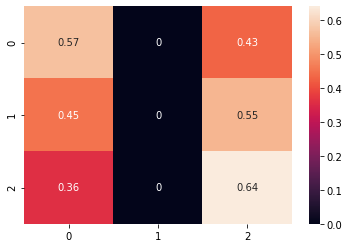

In [25]:
# confusion matrix visualization.
cnn_con_mat_norm = np.around(cnn_con_mat.astype('float') / cnn_con_mat.sum(axis=1)[:, np.newaxis],
                             decimals=2)

cnn_con_mat_df = pd.DataFrame(cnn_con_mat_norm,
                              index = ['0','1','2'], 
                              columns = ['0','1','2'])

# Print labels class values.
for key in encoding_winners_dict.keys():
    print(key,"-",np.argmax(encoding_winners_dict[key]))

# Plot heatmap.
sns.heatmap(cnn_con_mat_norm, annot=True)

In [26]:
# Get test accuracy.
_, cnn_accuracy = cnn_model.evaluate(X_test, y_test, verbose=1)
cnn_accuracy

1711/1711 [==============================] - 4s 2ms/step


0.5692577362060547

# Conclusions.